# Imports

In [1]:
import os
os.system("pip install funcy pandas numpy scipy seaborn ipywidgets openpyxl wordcloud")

0

In [2]:
import pandit as pd
import numpy as np
import funcy as fc
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
import requests
import re
from tqdm import tqdm
tqdm.pandas()
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


# Loading Data

## Datasets

In [3]:
df_wvs = pd.read_json("https://raw.githubusercontent.com/QuentinTilman/PollBERT-paper/master/Datasets/WVMCQ7/WVMCQ7-Normalized_labels_percentage_wise.json")
df_wvs_raw = pd.read_csv("https://raw.githubusercontent.com/QuentinTilman/PollBERT-paper/master/Datasets/WVMCQ7/WVMCQ7-Normalized_labels_raw.csv")

## Loading and Preparing processing data

In [4]:
df_variable_correspondence = pd.read_csv('https://raw.githubusercontent.com/QuentinTilman/PollBERT-paper/master/Datasets/WVMCQ7/preprocessing_files/F00011088-EVS_WVS_Joint_VariableCorrespondence.csv')
dic_variable_correspondence = dict(zip(df_variable_correspondence["Joint EVS/WVS\nVariable Label"].values,df_variable_correspondence["WVS 7\nVariable Name"].values))

In [5]:
categories = {
    "SOCIAL VALUES, ATTITUDES & STEREOTYPES" : range(1,45),
    "HAPPINESS AND WELL-BEING" : range(46,56),
    "SOCIAL CAPITAL, TRUST & ORGANIZATIONAL MEMBERSHIP" : range(57,105),
    "ECONOMIC VALUES" : range(106,111),
    "CORRUPTION" : range(112,120),
    "MIGRATION ": range(121,130),
    "SECURITY" : range(131,151),
    "POSTMATERIALIST INDEX" : range(152,157),
    "SCIENCE & TECHNOLOGY" : range(158,163),
    "RELIGIOUS VALUES" : range(164,175),
    "ETHICAL VALUES AND NORMS" : range(176,198),
    "POLITICAL INTEREST & POLITICAL PARTICIPATION" : range(199,234),
    "POLITICAL CULTURE & POLITICAL REGIMES" : range(235,259),
    "DEMOGRAPHICS" : range(260,290),
}

# Preprocessing Data

## Preprocessing Methods

In [6]:
num_choices = 6
choices_names=[f'choice_{i}' for i in range(num_choices)]
mode='proba'

In [7]:
def filter_nb_answers(data,limited_answers):
  dataset = []
  keys = list(data[["input","demographic","year"]].value_counts().keys())
  for (input,demographic,year) in keys:
      results = data.groupby(["input","demographic","year"]).get_group((input,demographic,year))
      if( (not limited_answers) or (len(results["label"]) > 1 and len(results["label"]) <= num_choices)):
        options = {}
        for i in range(len(results["choice"])):
          options[list(results["choice"])[i]] = list(results["label"])[i]

        dataset.append({"input":input,"demographic":demographic,"year":year,"options":options})
  return pd.DataFrame(dataset) 

In [8]:
def choices(x):
    choices = (x["options"]+['']*num_choices)[:num_choices]
    scores = np.array(list(x.labels)+[-1]*num_choices)[:num_choices]*1.0
    for i,n in enumerate(choices_names):
        x[n]=choices[i]  
    x["labels"] = scores
    return x

In [9]:
def filter_data(x):
    options = x["options"]
    if(1 < len(options) <=num_choices):
        return x

In [10]:
def apply_question_template(df):
  #we need to take into account that the input to the model is Demographic + Question + Answer
  # we thus need to create a question template that seems natural
  # This template is only necessary if the input is not already in a question format
  demographic = df["demographic"]
  category = df["demographic_category"]
  subject = df["input"]
  result = any(item in subject for item in ["?","How","Why","Where","When","Who","What"])
  sentence = f" {demographic}: {subject} ?".lower()
  if(not result):
    if(category == "age"):
        sentence = f" {demographic} years old: which of these options would you take in regard to the subject '{subject} ?'".lower()  
    else:
        sentence = f" {demographic}: which of these options would you take in regard to the subject '{subject} ?'".lower()  
  df['question'] = sentence
  return df

In [11]:
def get_category(x):
    subject = x["input"]
    try:
        qid = int(re.sub("[^0-9]", "", dic_variable_correspondence[subject]))
        for category in categories:
            if(qid in categories[category]):
                break
        x["category"] = category
    except:
        x["category"] = "failed"
    return x

In [12]:
yeari = 0
demoi = 1
inputi = 2
categoryi = 3
def to_poll_format(x):
    key = x[["year","demographic","input","demographic_topic"]].values[0]
    values = x[["choice","label"]]["label"].values
    n_votes = x[["choice","label"]]["label"].values.sum()
    new_labels = values
    return {"year":key[yeari],"demographic":key[demoi],"input":key[inputi],"demographic_category":key[categoryi],"options":np.array(x["choice"].values),"labels":np.array(new_labels),"n_votes":n_votes}

## Applying preprocessing

In [13]:
df_filtered = df_wvs.progress_apply(filter_data,axis=1)
df_filtered = df_filtered.dropna()
df_filtered= pd.DataFrame([item for item in df_filtered.values if item[1].lower() not in ["-5","-4","-3","-2","-1","1","2","no answer","don't know","missing"] ],columns= ["year","demographic","input","demographic_category","options","labels"])
pd.DataFrame(df_filtered)

100%|██████████| 209542/209542 [00:27<00:00, 7608.44it/s] 


,year,demographic,input,demographic_category,options,labels
0,2017.0,18,Aims of country: first choice,age,"[A high level of economic growth, Making sure ...","[0.4291417166, 0.1397205589, 0.3233532934, 0.1..."
1,2017.0,18,Aims of country: second choice,age,"[A high level of economic growth, Making sure ...","[0.2611336032, 0.2064777328, 0.3198380567, 0.2..."
2,2017.0,18,Aims of respondent: first choice,age,"[maintaining order in the nation, Giving peopl...","[0.3605577689, 0.24103585660000001, 0.14541832..."
3,2017.0,18,Aims of respondent: second choice,age,"[maintaining order in the nation, Giving peopl...","[0.2851405622, 0.2489959839, 0.218875502000000..."
4,2017.0,18,Believe in: God,age,"[No, Yes]","[0.3611691023, 0.6388308977]"
...,...,...,...,...,...,...
176864,2022.0,male,Vote in elections: local level,gender,"[Always, Usually, Never, Not allowed to vote]","[0.5963541667000001, 0.24804687500000003, 0.14..."
176865,2022.0,male,Which party would you vote for: first choice (...,gender,"[No right to vote, Other, Independent Candidate]","[0.36250000000000004, 0.125, 0.5125000000000001]"
176866,2022.0,male,Willingness to fight for country,gender,"[no, yes]","[0.22697899840000002, 0.7730210016]"
176867,2022.0,male,Work is a duty towards society,gender,"[Strongly agree, Agree, Neither agree nor disa...","[0.3264913406, 0.3688261706, 0.1610006414, 0.1..."


In [14]:
df_wvs_categories = df_wvs.progress_apply(get_category,axis=1)
df_filtered_categories = df_filtered.progress_apply(get_category,axis=1)

100%|██████████| 176869/176869 [02:26<00:00, 1210.82it/s]


In [15]:
df_wvs_raw= df_wvs_raw.groupby(["year","demographic","input","demographic_topic"]).progress_apply(to_poll_format)
df_wvs_raw_norm = pd.DataFrame([item for item in [item for item in df_wvs_raw.values]])

100%|██████████| 209542/209542 [08:40<00:00, 402.77it/s]


# Data Visualisation

## Examples per Demographic Category

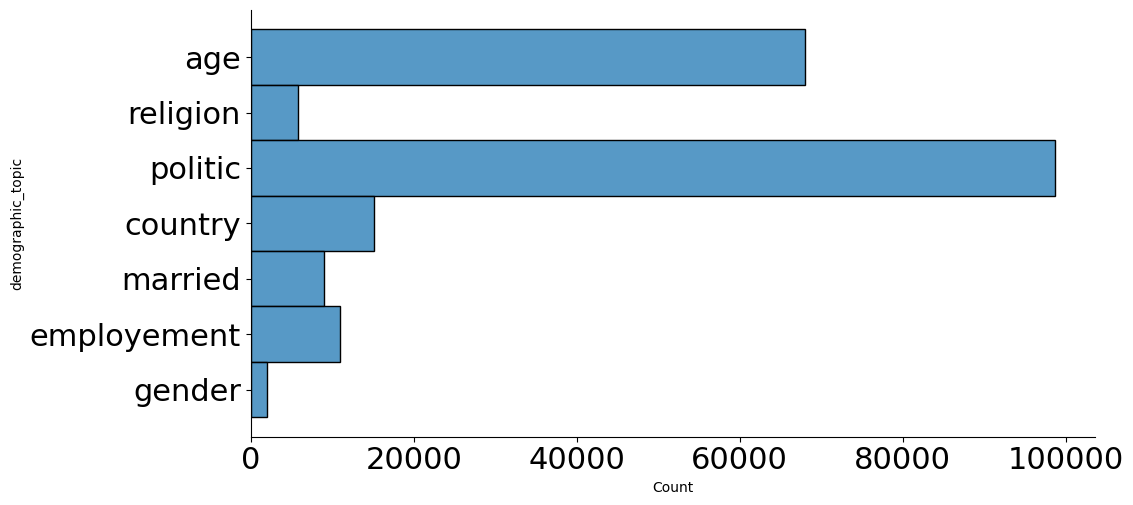

In [16]:
sns.displot(data=df_wvs_categories, y="demographic_topic",height=5, aspect=2)
plt.tick_params(axis='both', which='major', labelsize=22)

### Category: Political Affiliation

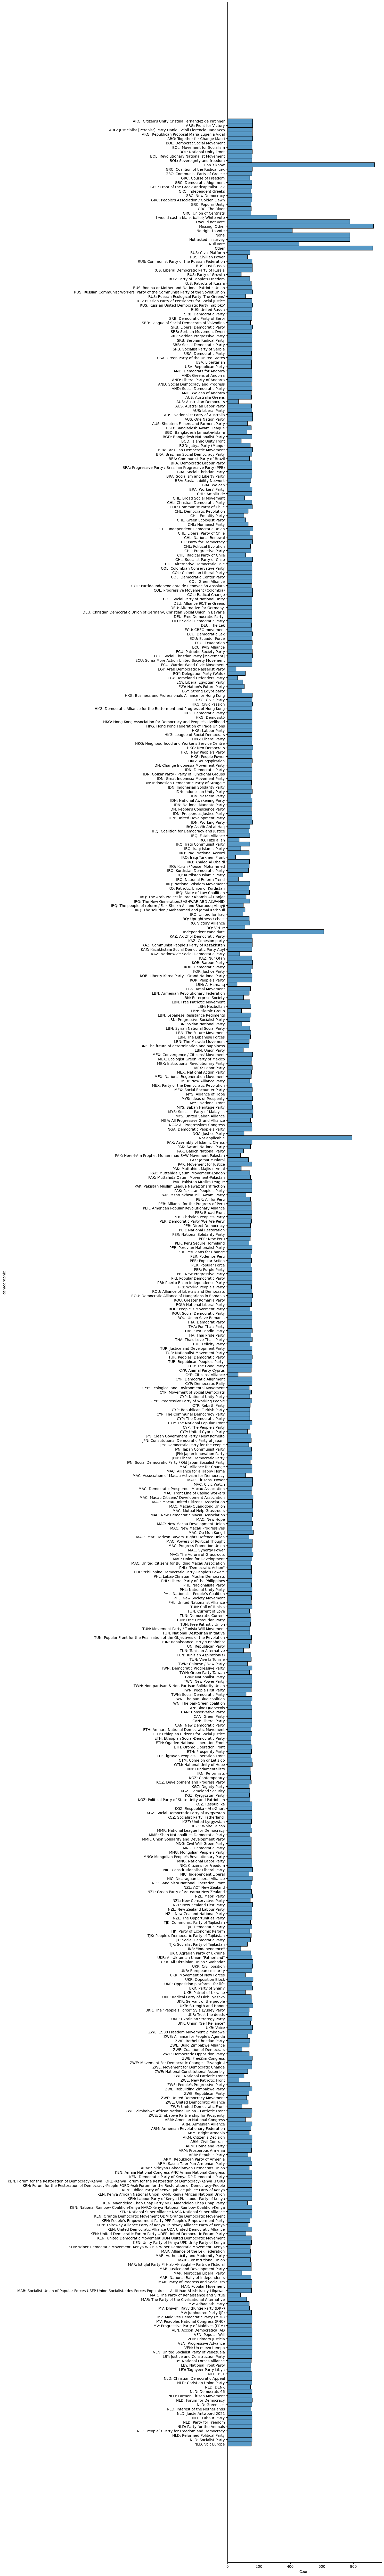

In [17]:
sns.displot(data=df_filtered_categories[df_filtered_categories["demographic_category"] == "politic"], y="demographic",height=100, aspect=15/100)

### Category: Country

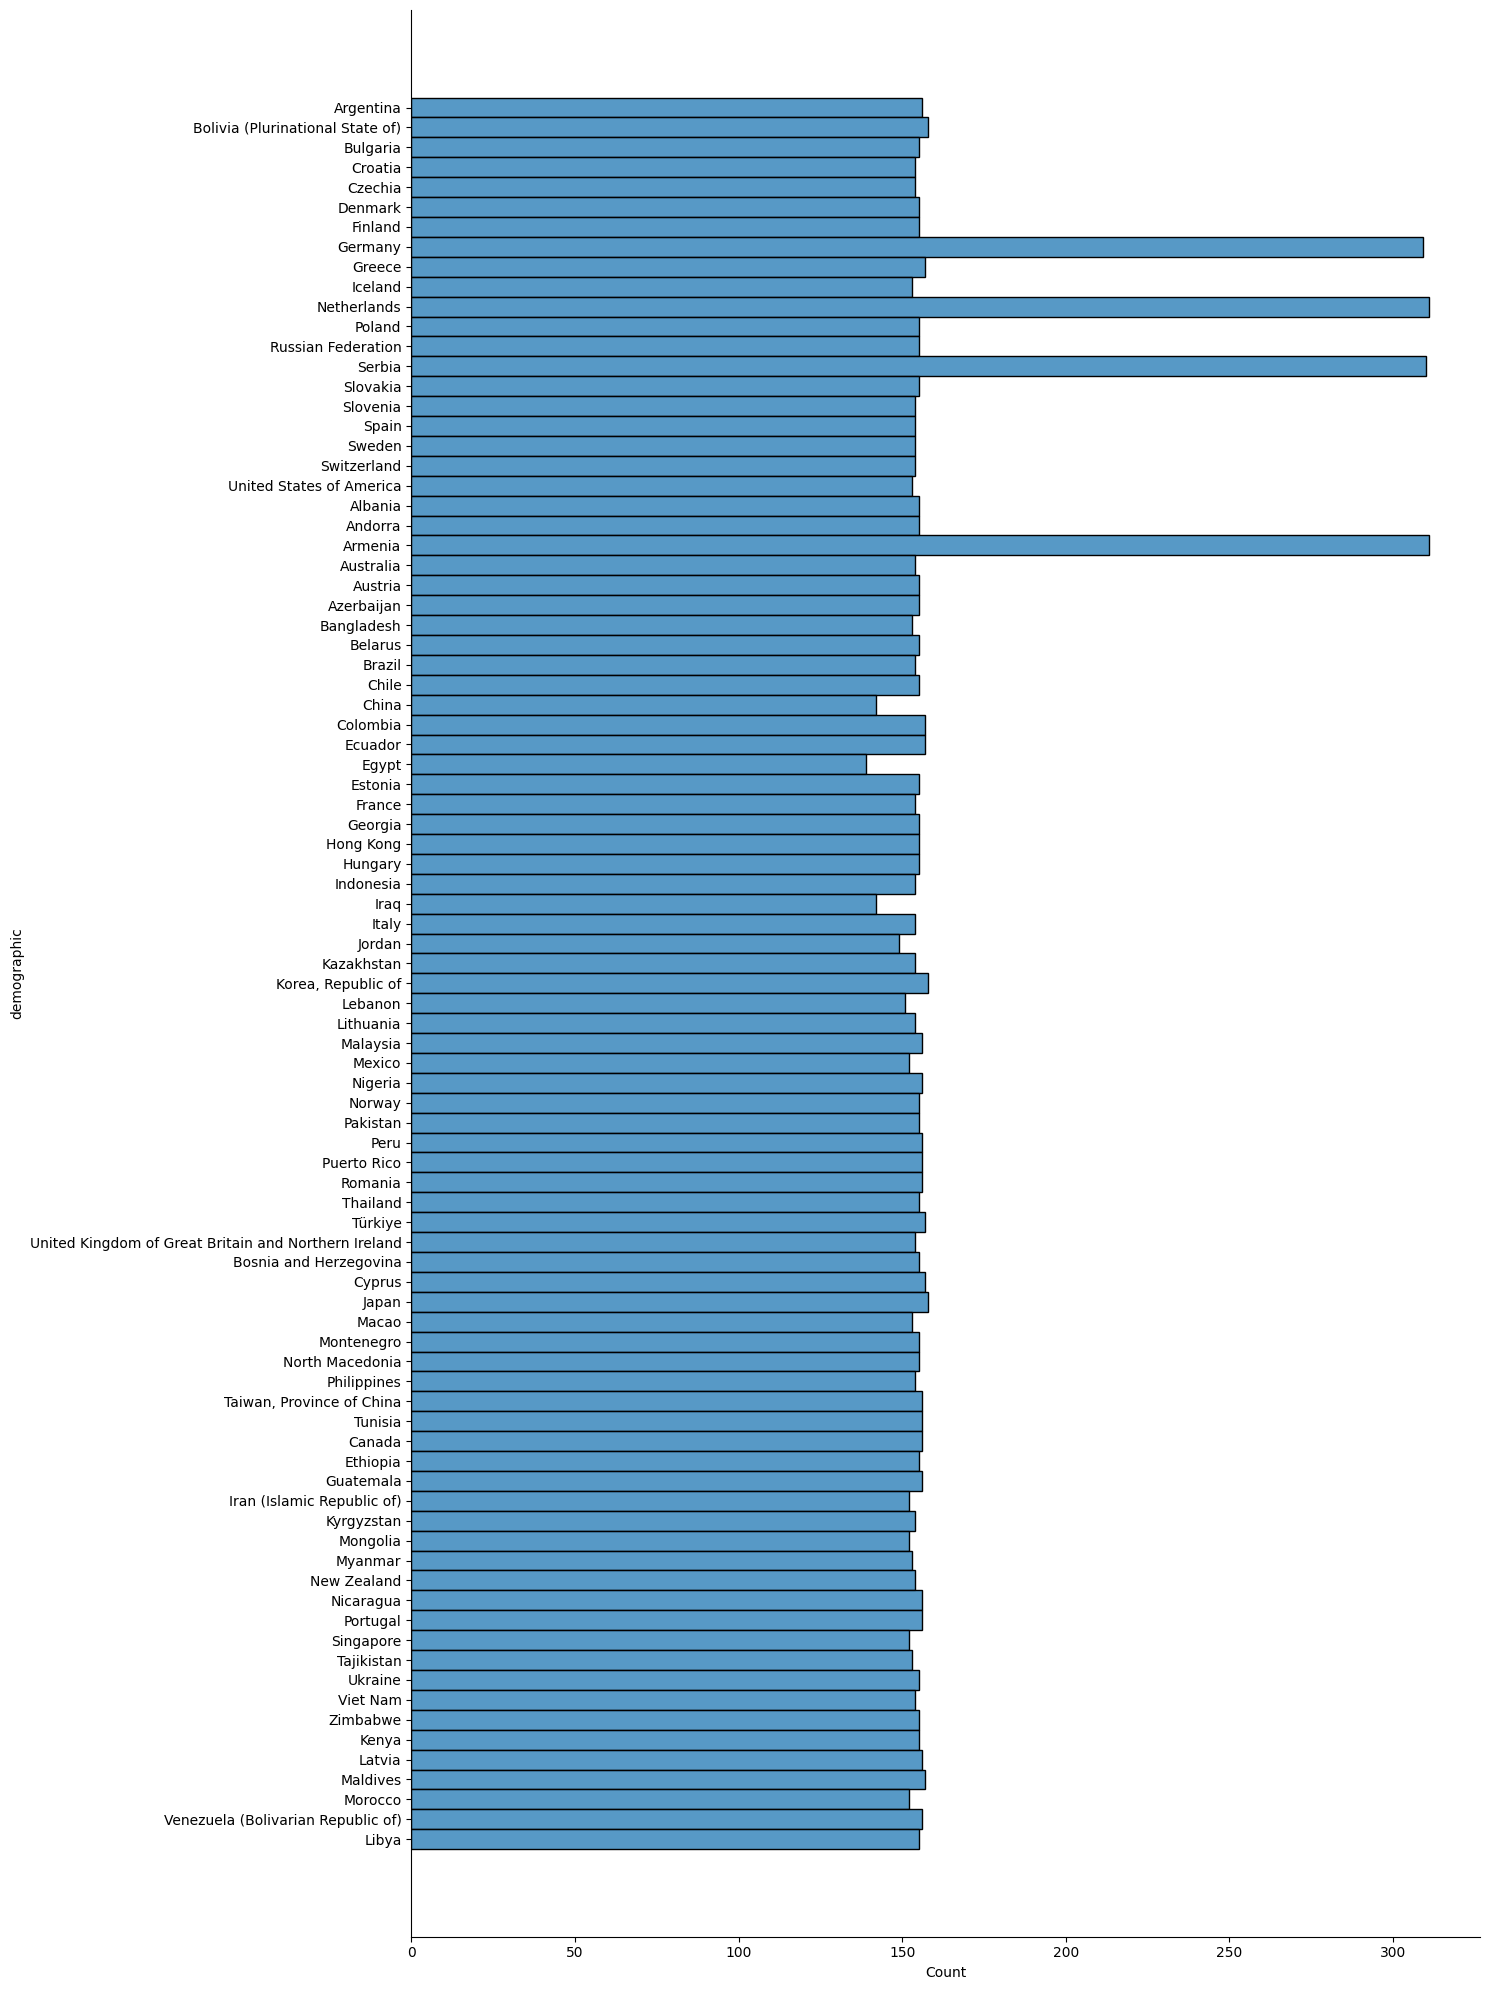

In [18]:
sns.displot(data=df_filtered_categories[df_filtered_categories["demographic_category"] == "country"], y="demographic",height=20, aspect=15/20)

### Category: Age

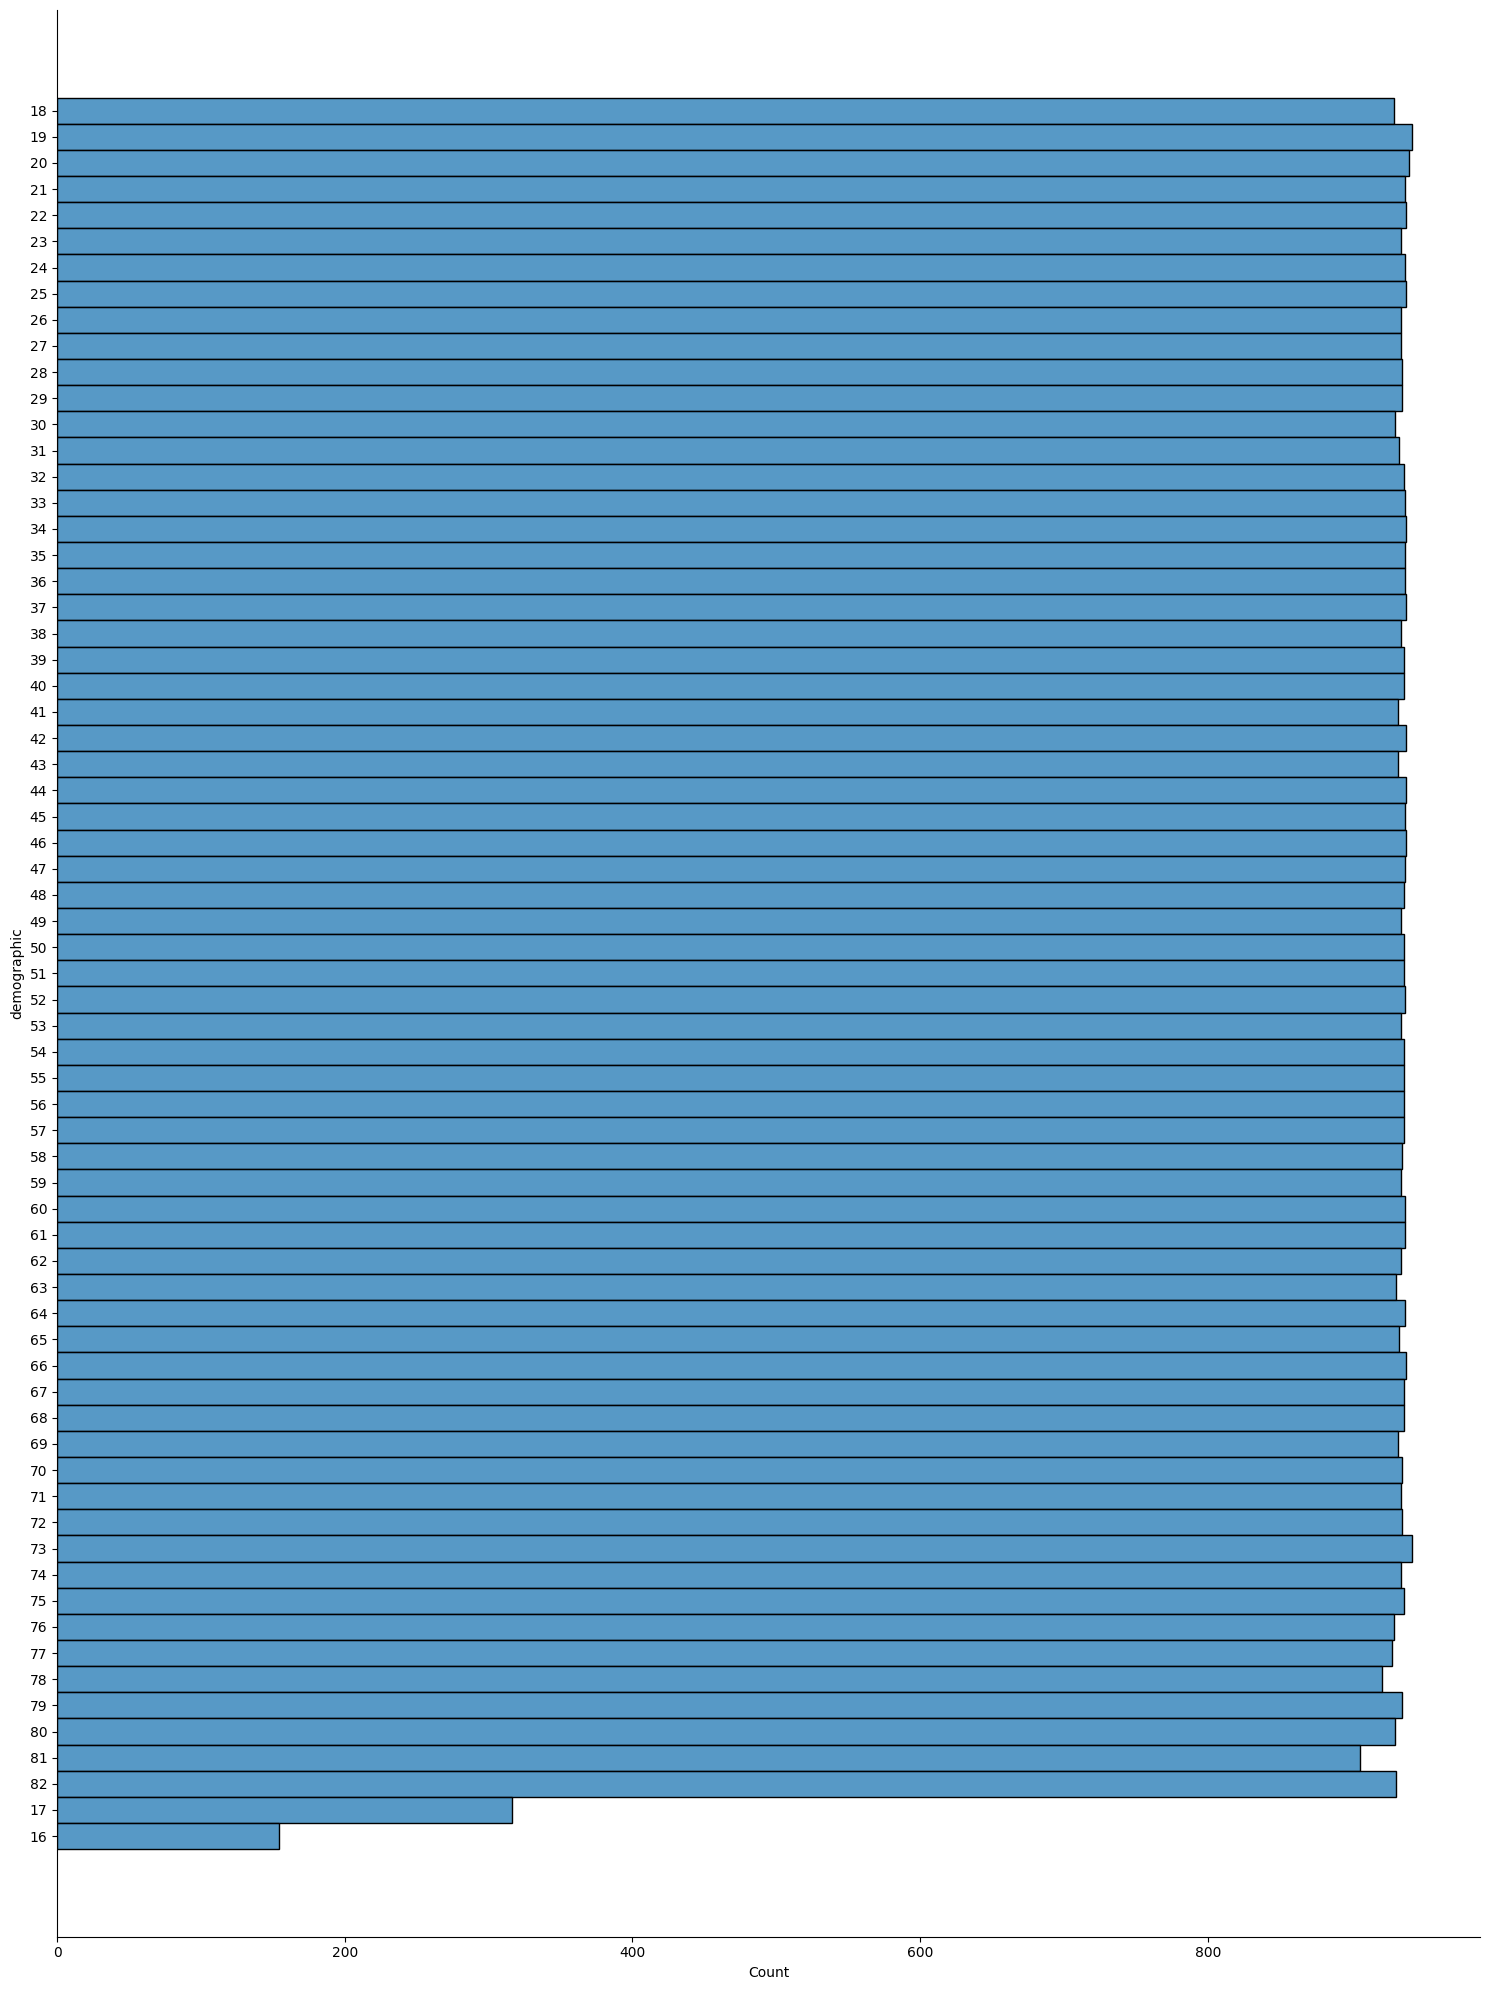

In [19]:
sns.displot(data=df_filtered_categories[df_filtered_categories["demographic_category"] == "age"], y="demographic",height=20, aspect=15/20)

### Category: Religion

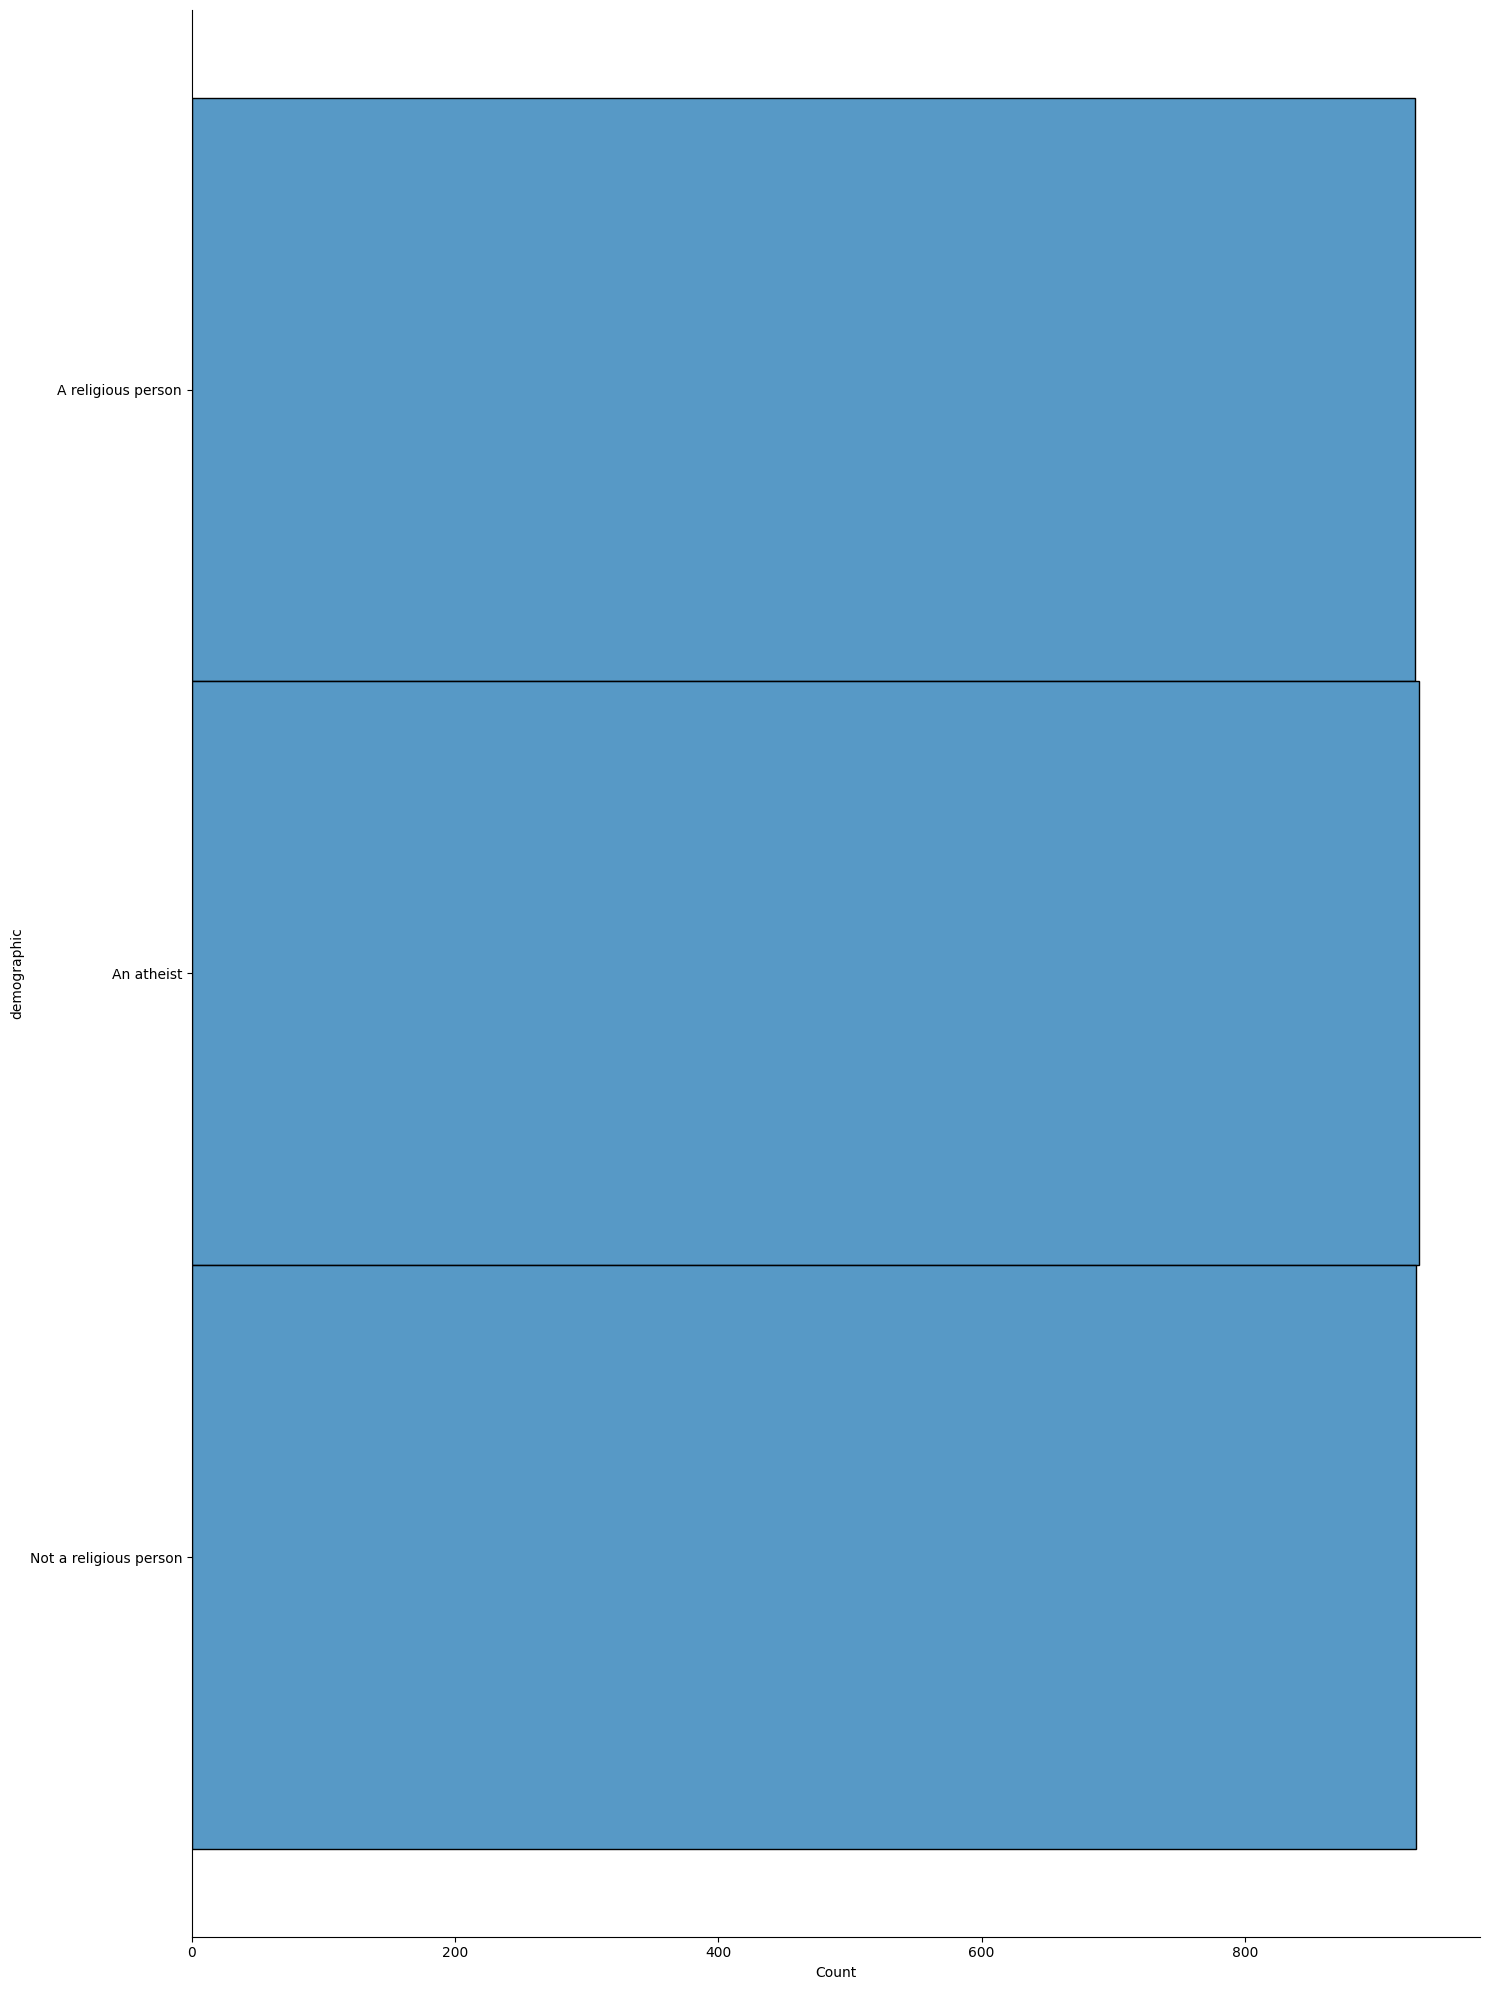

In [20]:
sns.displot(data=df_filtered_categories[df_filtered_categories["demographic_category"] == "religion"], y="demographic",height=20, aspect=15/20)

### Category: Relationship Status

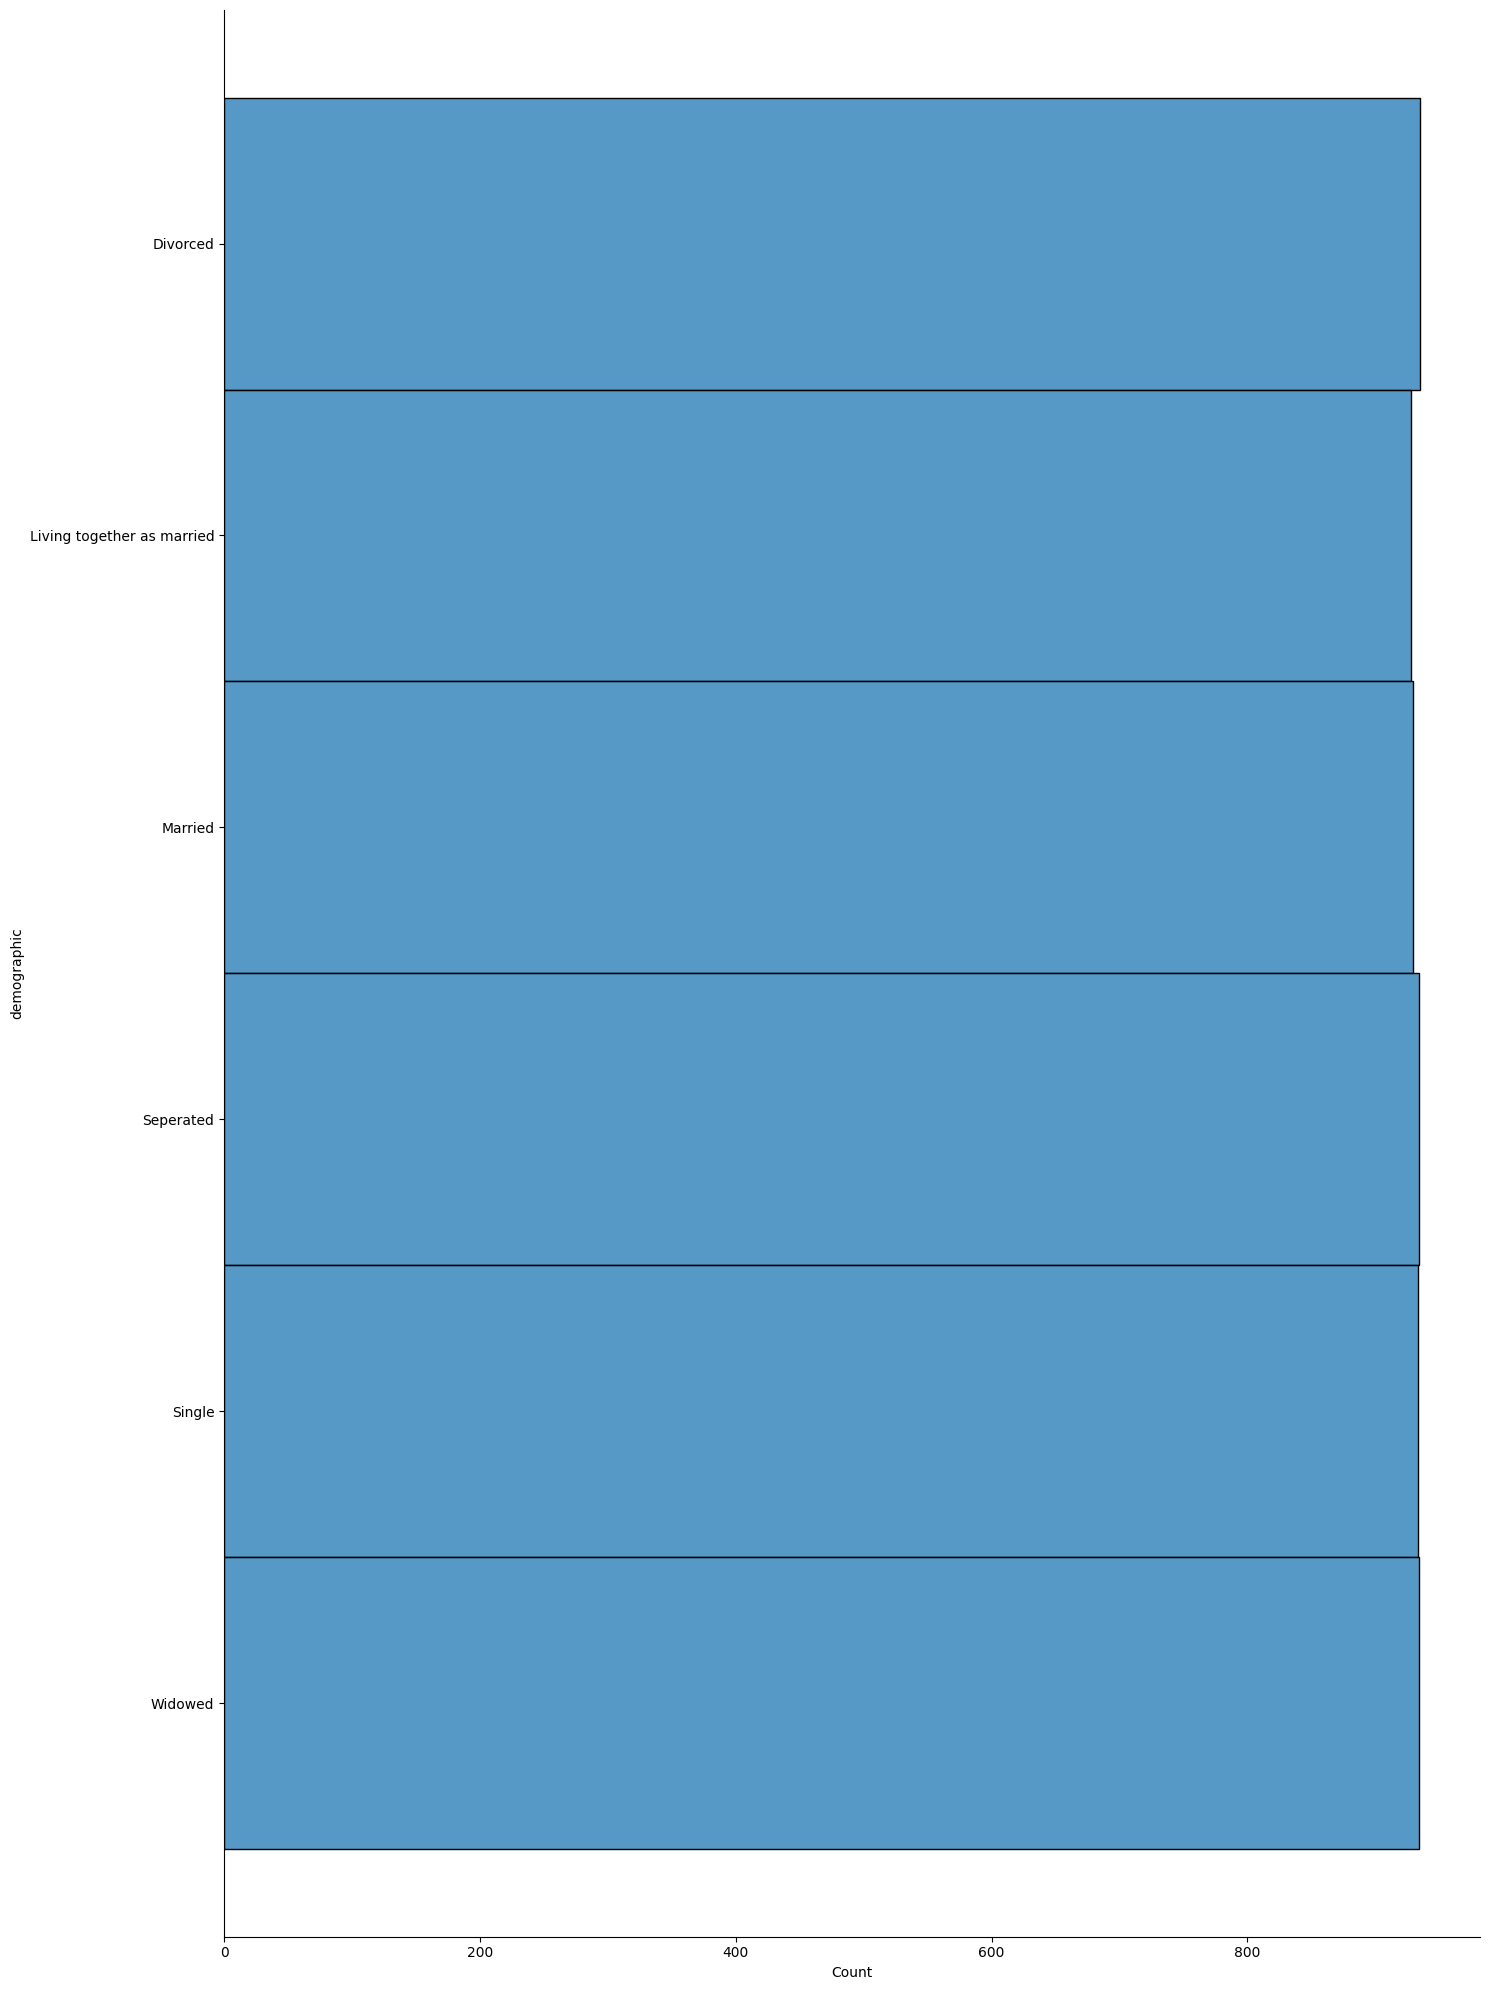

In [21]:
sns.displot(data=df_filtered_categories[df_filtered_categories["demographic_category"] == "married"], y="demographic",height=20, aspect=15/20)

### Category: Employement Status

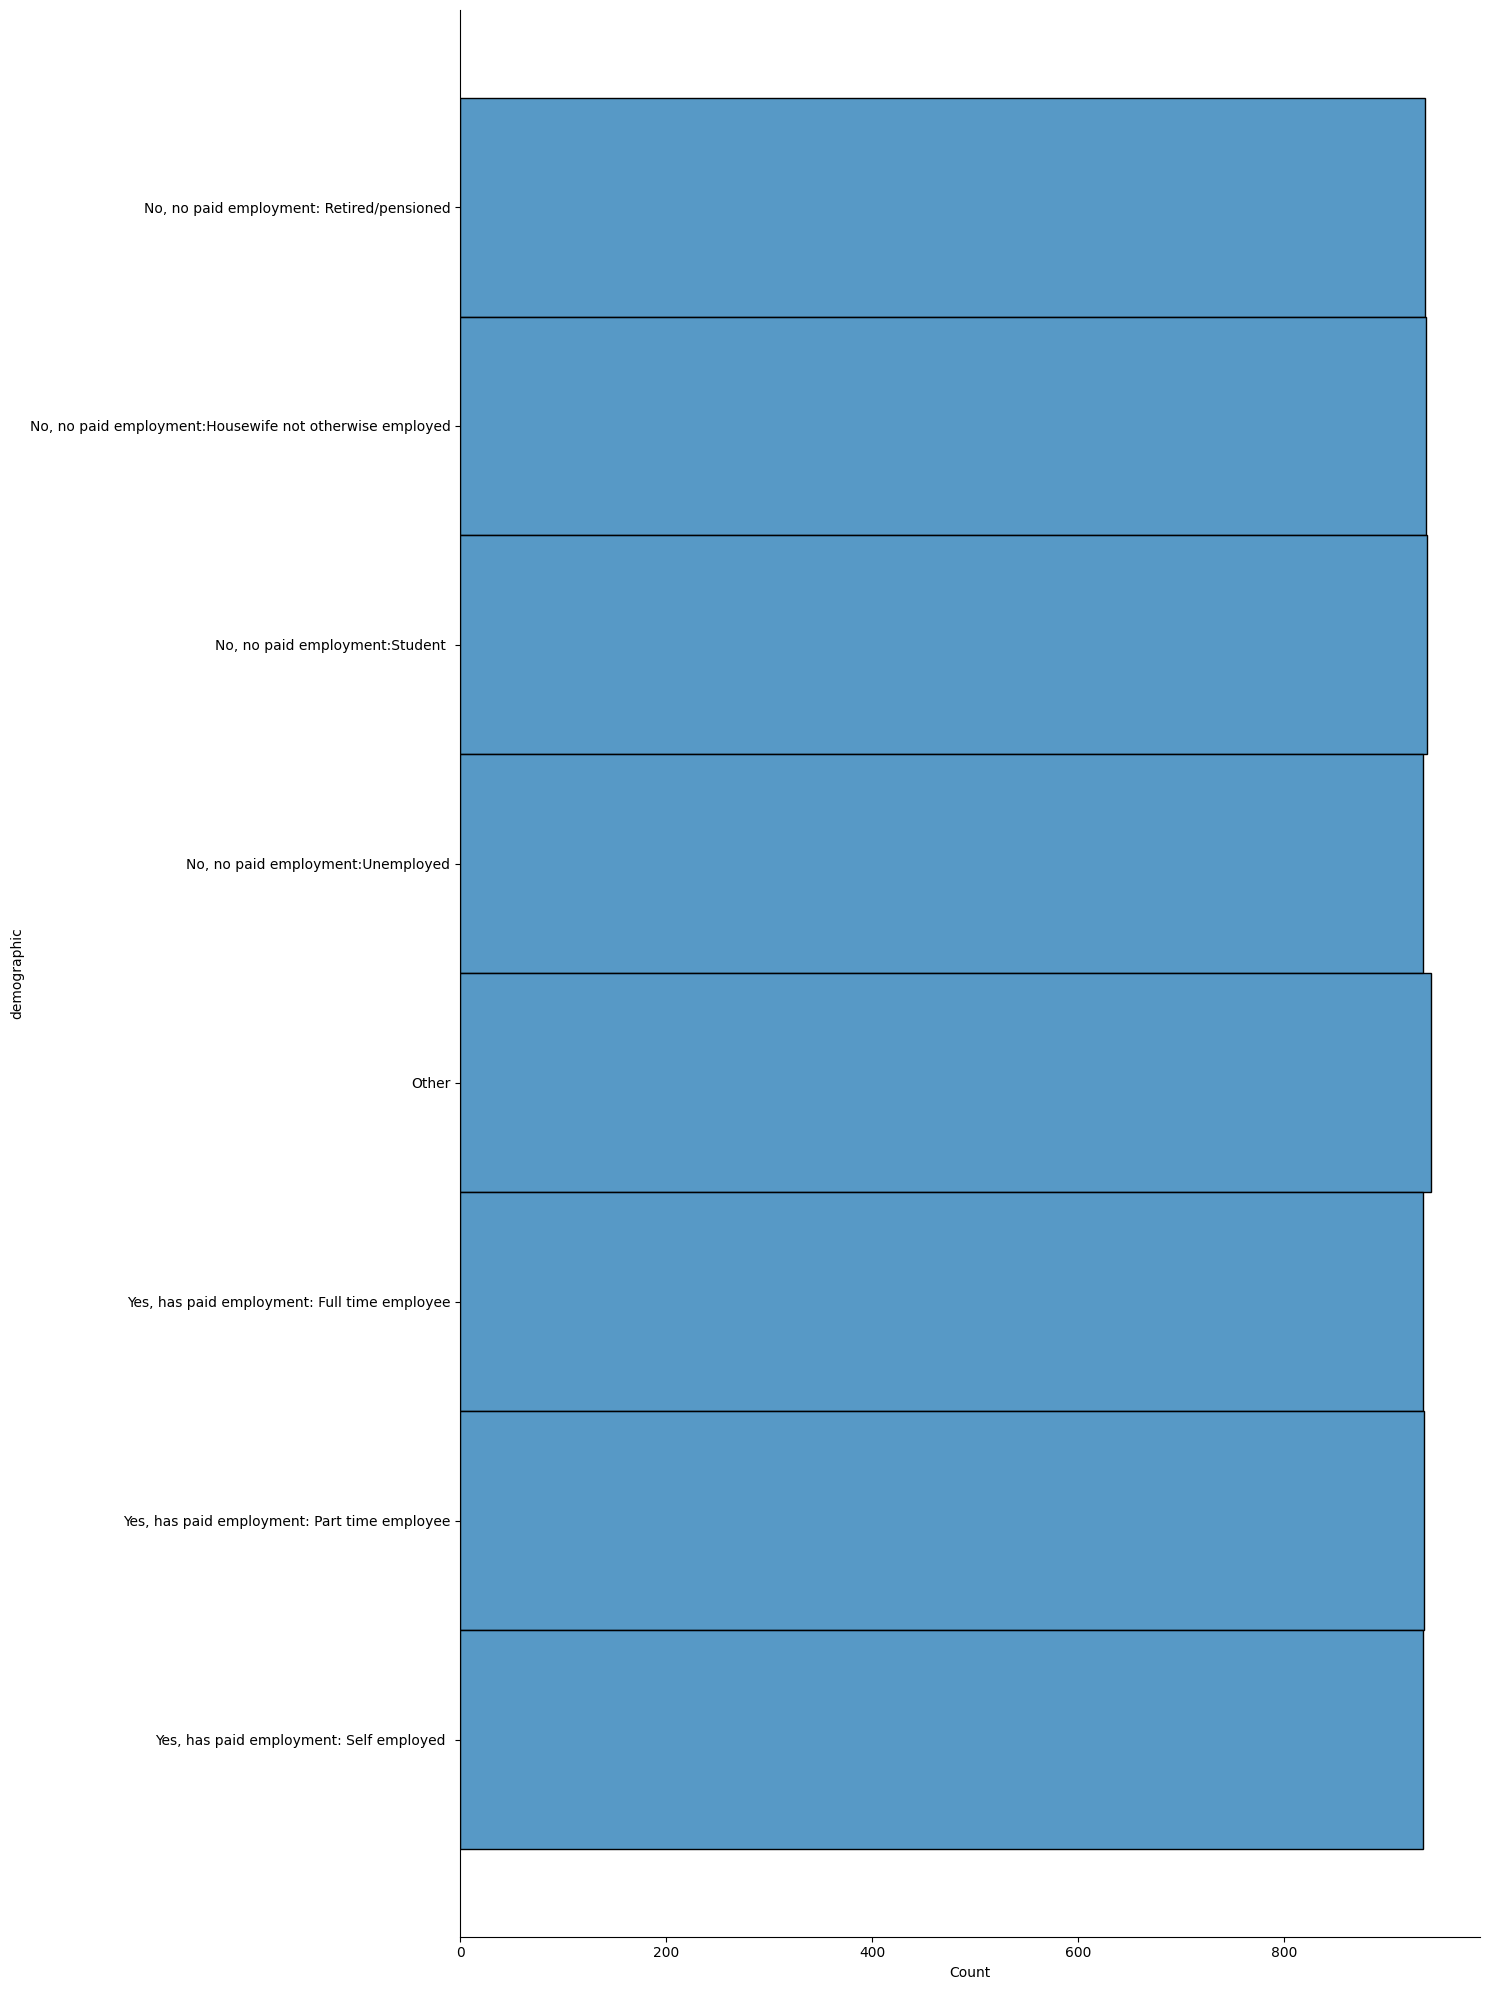

In [22]:
sns.displot(data=df_filtered_categories[df_filtered_categories["demographic_category"] == "employement"], y="demographic",height=20, aspect=15/20)

## Examples per Question Topic

c:\Users\Quent\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


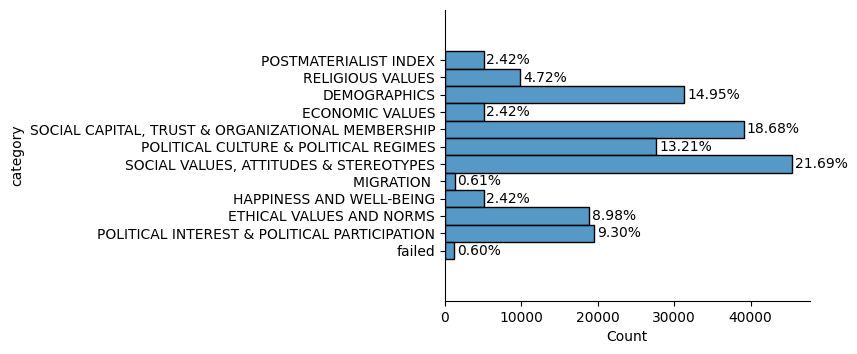

In [23]:
fg = sns.displot(data=df_wvs_categories, y='category', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

## Examples per year

WVS dataset spans over 5 years.

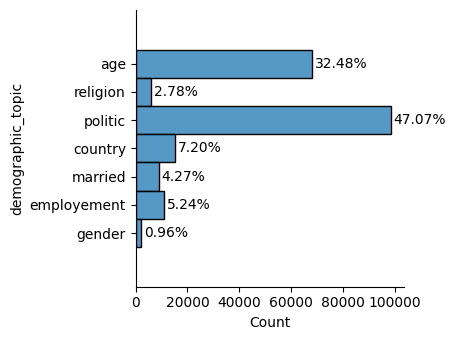

In [24]:
fg = sns.displot(data=df_wvs_categories, y='demographic_topic', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

### Categorical

#### 2017

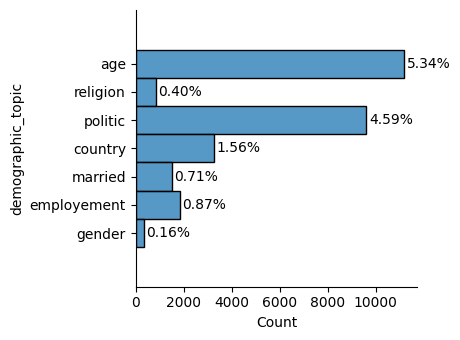

In [25]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2017], y='demographic_topic', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2018

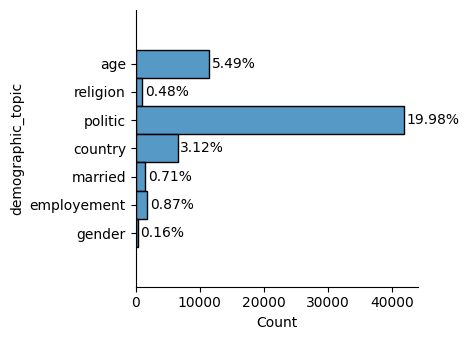

In [26]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2018], y='demographic_topic', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2019

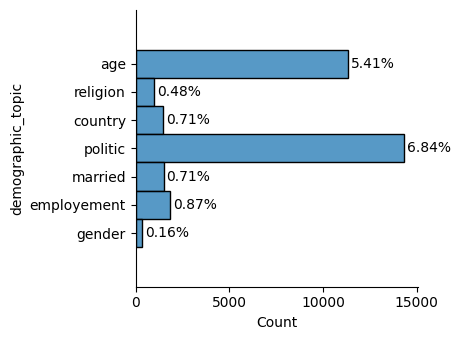

In [27]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2019], y='demographic_topic', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2020

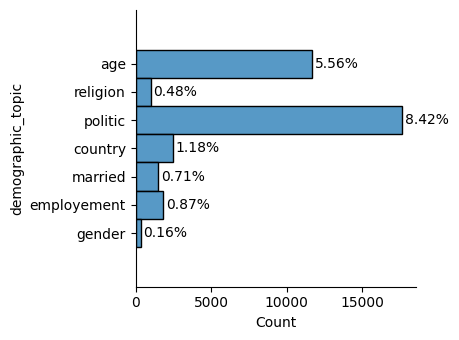

In [28]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2020], y='demographic_topic', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2021

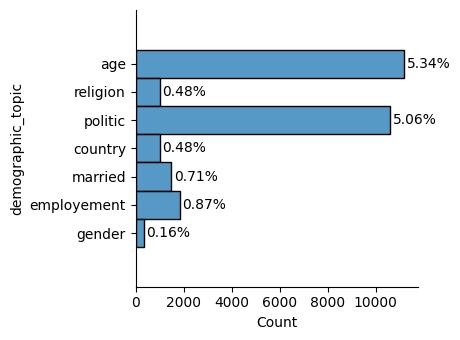

In [29]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2021], y='demographic_topic', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2022

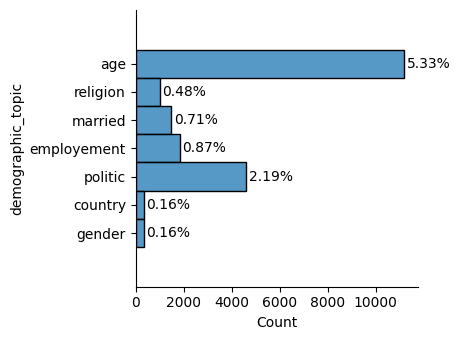

In [30]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2022], y='demographic_topic', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

### Topical

#### 2017

c:\Users\Quent\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


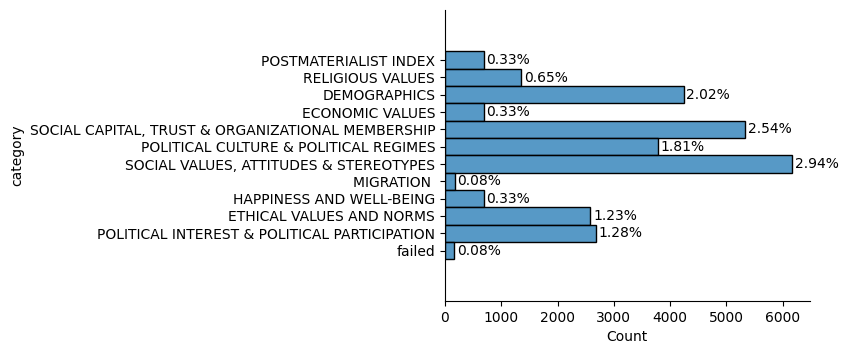

In [31]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2017], y='category', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2018

c:\Users\Quent\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


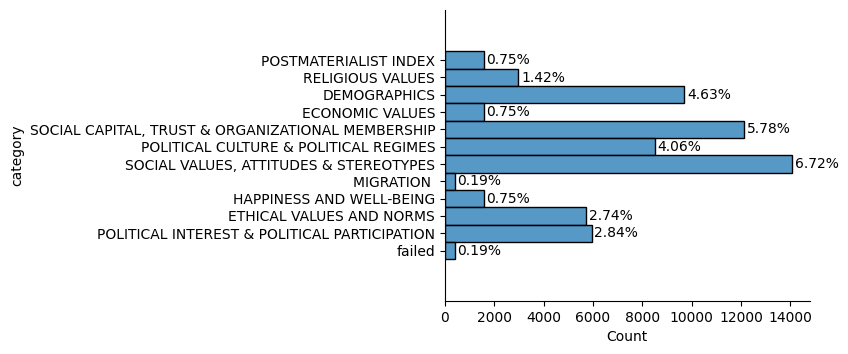

In [32]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2018], y='category', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2019

c:\Users\Quent\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


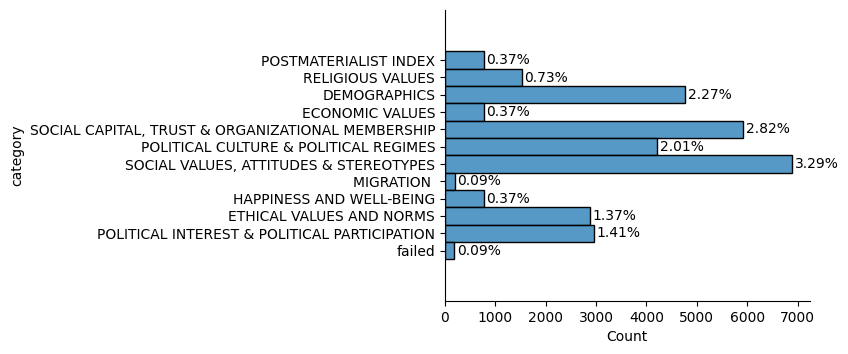

In [33]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2019], y='category', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2020

c:\Users\Quent\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


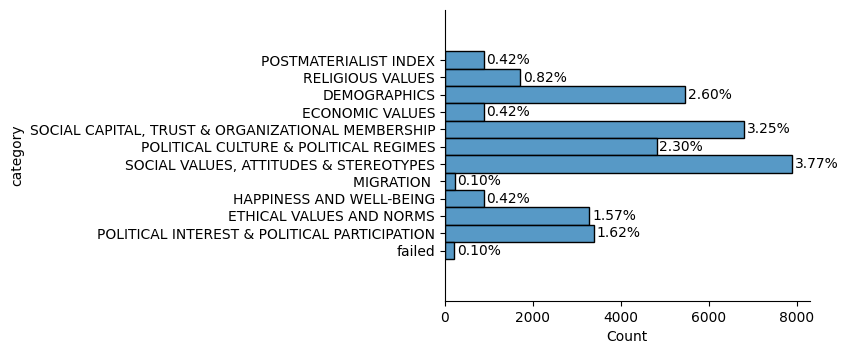

In [34]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2020], y='category', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2021

c:\Users\Quent\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


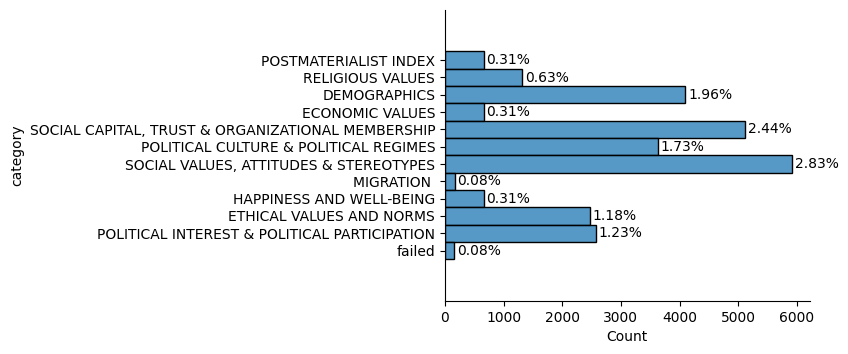

In [35]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2021], y='category', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

#### 2022

c:\Users\Quent\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


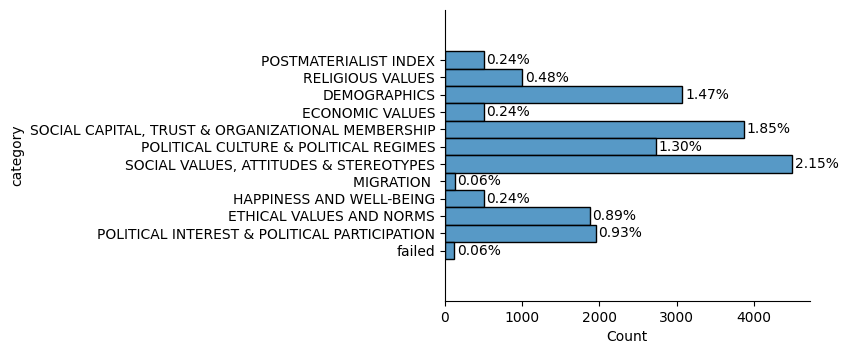

In [36]:
fg = sns.displot(data=df_wvs_categories[df_wvs_categories["year"] == 2022], y='category', stat='count', height=3.5, aspect=1.25)

for ax in fg.axes.ravel():
    # add annotations
    for c in ax.containers:
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.2f}%' if (w := (v.get_width()/len(df_wvs_categories))*100) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, rotation=0, padding=2)
    
    ax.margins(y=0.2)
fg.tick_params(labelsize=10)
plt.show()

# Demographic divisiveness Test

In [99]:
def test(x,year,dictionary_demo_question):
    demographics = list(x["demographic"])
    for i in range(len(demographics)):
        dictionary_demo_question[(year,demographics[i])].append(list(x["input"])[i])
    return x

def z_test(n1,prop1,s1,n2,prop2,s2):
    SE = np.sqrt(s1**2/n1 + s2**2/n2)
    return (prop1-prop2)/SE

def z_score(n1,prop1,n2,prop2):
    p_hat = (prop1*n1+prop2*n2)/(n1+n2)
    SE = np.sqrt( (p_hat*(1-p_hat))*(1/n1+1/n2))
    return (prop1-prop2)/SE

## Inter Demographical Category Divisiveness

In [231]:
df_wvs_raw_norm = pd.DataFrame([item for item in df_wvs_raw_norm.values if item[1].lower() not in ["-5","-4","-3","-2","-1","1","2","no answer","don't know","missing"] ],columns= df_wvs_raw_norm.columns)

In [232]:
demo_pair_questions = {}

In [233]:
years = df_wvs_raw_norm["year"].value_counts().keys()

#### Gender

In [234]:
df_wvs_raw_norm_gender = df_wvs_raw_norm[df_wvs_raw_norm["demographic_category"] == "gender"]

In [235]:
dictionary_demo_question = {}
for y in years:
    for key in df_wvs_raw_norm_gender[df_wvs_raw_norm_gender["year"] == y]["demographic"].value_counts().keys():
        dictionary_demo_question[(y,key)] = []
for y in years:
    df_wvs_raw_norm_gender[df_wvs_raw_norm_gender["year"] == y].groupby(["input"]).apply(test,y,dictionary_demo_question)

C:\Users\Quent\AppData\Local\Temp\ipykernel_25052\1425748909.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_reddit_category_reduced_choices = df_wvs_raw_norm_gender[df_wvs_raw_norm_gender["year"] == y].groupby(["input"]).apply(test,y,dictionary_demo_question)
C:\Users\Quent\AppData\Local\Temp\ipykernel_25052\1425748909.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the f

In [236]:
for yk,k in dictionary_demo_question.keys():
    for yl,l in dictionary_demo_question.keys():
        if(yk == yl):
            if(k != l):
                s = set(dictionary_demo_question[(yk,k)]).intersection(set(dictionary_demo_question[(yl,l)]))
                if(len(s) != 0):
                        if((yk,l,k) not in demo_pair_questions.keys()):
                            demo_pair_questions[(yk,k,l)] = s

#### Age

In [111]:
df_wvs_raw_norm_gender = df_wvs_raw_norm[df_wvs_raw_norm["demographic_category"] == "age"]

In [112]:
dictionary_demo_question = {}
for y in years:
    for key in df_wvs_raw_norm_gender[df_wvs_raw_norm_gender["year"] == y]["demographic"].value_counts().keys():
        dictionary_demo_question[(y,key)] = []
for y in years:
    df_reddit_category_reduced_choices = df_wvs_raw_norm_gender[df_wvs_raw_norm_gender["year"] == y].groupby(["input"]).apply(test,y,dictionary_demo_question)

C:\Users\Quent\AppData\Local\Temp\ipykernel_25052\1425748909.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_reddit_category_reduced_choices = df_wvs_raw_norm_gender[df_wvs_raw_norm_gender["year"] == y].groupby(["input"]).apply(test,y,dictionary_demo_question)
C:\Users\Quent\AppData\Local\Temp\ipykernel_25052\1425748909.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the f

In [113]:
for yk,k in dictionary_demo_question.keys():
    for yl,l in dictionary_demo_question.keys():
        if(yk == yl):
            if(k != l):
                s = set(dictionary_demo_question[(yk,k)]).intersection(set(dictionary_demo_question[(yl,l)]))
                if(len(s) != 0):
                        if((yk,l,k) not in demo_pair_questions.keys()):
                            demo_pair_questions[(yk,k,l)] = s

#### Employement

In [264]:
df_wvs_raw_norm_employement = df_wvs_raw_norm[df_wvs_raw_norm["demographic_category"] == "employement"]

In [265]:
dictionary_demo_question = {}
for y in years:
    for key in df_wvs_raw_norm_employement[df_wvs_raw_norm_employement["year"] == y]["demographic"].value_counts().keys():
        dictionary_demo_question[(y,key)] = []
for y in years:
    df_wvs_raw_norm_employement[df_wvs_raw_norm_employement["year"] == y].groupby(["input"]).apply(test,y,dictionary_demo_question)

C:\Users\Quent\AppData\Local\Temp\ipykernel_25052\1491514942.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_wvs_raw_norm_employement[df_wvs_raw_norm_employement["year"] == y].groupby(["input"]).apply(test,y,dictionary_demo_question)
C:\Users\Quent\AppData\Local\Temp\ipykernel_25052\1491514942.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence 

In [266]:
for yk,k in dictionary_demo_question.keys():
    for yl,l in dictionary_demo_question.keys():
        if(yk == yl):
            if(k != l):
                s = set(dictionary_demo_question[(yk,k)]).intersection(set(dictionary_demo_question[(yl,l)]))
                if(len(s) != 0):
                        if((yk,l,k) not in demo_pair_questions.keys()):
                            demo_pair_questions[(yk,k,l)] = s

#### Religion

In [267]:
df_wvs_raw_norm_religion = df_wvs_raw_norm[df_wvs_raw_norm["demographic_category"] == "religion"]

In [268]:
dictionary_demo_question = {}
for y in years:
    for key in df_wvs_raw_norm_religion[df_wvs_raw_norm_religion["year"] == y]["demographic"].value_counts().keys():
        dictionary_demo_question[(y,key)] = []
for y in years:
    df_wvs_raw_norm_religion[df_wvs_raw_norm_religion["year"] == y].groupby(["input"]).apply(test,y,dictionary_demo_question)

C:\Users\Quent\AppData\Local\Temp\ipykernel_25052\1586085414.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_wvs_raw_norm_religion[df_wvs_raw_norm_religion["year"] == y].groupby(["input"]).apply(test,y,dictionary_demo_question)
C:\Users\Quent\AppData\Local\Temp\ipykernel_25052\1586085414.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this w

In [269]:
for yk,k in dictionary_demo_question.keys():
    for yl,l in dictionary_demo_question.keys():
        if(yk == yl):
            if(k != l):
                s = set(dictionary_demo_question[(yk,k)]).intersection(set(dictionary_demo_question[(yl,l)]))
                if(len(s) != 0):
                        if((yk,l,k) not in demo_pair_questions.keys()):
                            demo_pair_questions[(yk,k,l)] = s

In [270]:
len(demo_pair_questions)

192

#### P-values

In [271]:
df_demo_pair_questions = []
for ((y,a,b),vs) in demo_pair_questions.items():
    for v in vs:
        df_demo_pair_questions.append({"year":y,"demoA":a,"demoB":b,"question":v})
pd.DataFrame(df_demo_pair_questions)

,year,demoA,demoB,question
0,2018,female,male,Believe in: hell
1,2018,female,male,Aims of respondent: first choice
2,2018,female,male,"Member: Belong to conservation, the environmen..."
3,2018,female,male,Importance of democracy
4,2018,female,male,Member: Belong to sports or recreation
...,...,...,...,...
32059,2022,An atheist,Not a religious person,Believe in: life after death
32060,2022,An atheist,Not a religious person,Occupational group - respondent´s spouse (WVS7)
32061,2022,An atheist,Not a religious person,Democracy: Religious authorities interpret the...
32062,2022,An atheist,Not a religious person,Competition good or harmful


In [346]:
def get_p_value(x):
    year = x["year"]
    demoA = x["demoA"]
    demoB = x["demoB"]
    question = x["question"]
    try:
        df_y = df_wvs_raw_norm[df_wvs_raw_norm['year'] == year]

        df_a = df_y[df_y['demographic'] == demoA]
        df_a = df_a[df_a['input'] == question]
        choice_label = np.array(list(df_a["options"])[0])[0]
        labels_A = np.array(list(df_a["labels"])[0])
        nA = df_a["n_votes"].values[0]
        v_choice0_a = labels_A[labels_A != -1][0]
        propA = v_choice0_a/nA

        df_b = df_y[df_y['demographic'] == demoB]
        df_b = df_b[df_b['input'] == question]

        labels_B = np.array(list(df_b["labels"])[0])
        nB = df_b["n_votes"].values[0]

        index_choice = list(df_b["options"].values[0]).index(choice_label)# option label changes places for certain examples, taking index avoids wrong divisiveness
        v_choice0_b = labels_B[labels_B != -1][index_choice]
        propB = v_choice0_b/nB
        
        x["p_value"] = sc.stats.norm.sf(abs(z_score(nA,propA,nB,propB)))
        return x
    except:
        pass

In [347]:
df_demo_pair_questions = pd.DataFrame(df_demo_pair_questions).progress_apply(get_p_value,axis = 1)

 83%|████████▎ | 26595/32064 [06:05<00:45, 119.18it/s]C:\Users\Quent\AppData\Local\Temp\ipykernel_25052\351170487.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return (prop1-prop2)/SE
100%|██████████| 32064/32064 [07:10<00:00, 74.50it/s] 


In [371]:
pd.DataFrame([item for item in df_demo_pair_questions.values if item[4] < 0.001]).to_jsonv("WVMCQ7_significant_divisiveness_questions.json")